In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gluonts
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset, StepStrategy
from gluonts.evaluation import make_evaluation_predictions, Evaluator
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week
from PythonFiles.Configuration import Configuration
config = Configuration()
df = pd.read_csv("Influenza.csv", sep=',')

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/gluonts/model/simple_feedforward/__init__.py:18: FutureWarning: The module gluonts.model.simple_feedforward has been moved to gluonts.mx.model.simple_feedforward. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import SimpleFeedForwardEstimator'.
  warnings.warn(


In [2]:
locations = list(df.location.unique())

# Process the df into a uniformly spaced df
df = df.loc[df.location.isin(locations), ["value", 'location', 'date']]
corrected_df = preprocessing(config, df, check_count=False, output_type="corrected_df")

# seperate the intervals for training and testing
train_set_df = corrected_df.loc[(corrected_df.index <= config.train_end_time) &
                          (corrected_df.index >= config.train_start_time),:]

test_set_df = corrected_df.loc[(corrected_df.index >= config.train_start_time) &
                         (corrected_df.index <= config.test_end_time),:]

# Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set_df,
                                              item_id='location',
                                              target="value",
                                              freq=config.freq)

test_set = PandasDataset.from_long_dataframe(dataframe=test_set_df,
                                             item_id='location',
                                             target="value",
                                             freq=config.freq)

# Determine the Starting and ending time of the test_set_df
start_time = min(test_set_df.index.difference(train_set_df.index))
end_time = max(test_set_df.index.difference(train_set_df.index))
test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy = StepStrategy(prediction_length=config.prediction_length, step_size=1),
                                    start_time = pd.Period(start_time, config.freq),
                                    end_time = pd.Period(end_time, config.freq)
                                   )

### SimpleFeedForwardEstimator -> Acceptable

In [3]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx import Trainer
from gluonts.evaluation import make_evaluation_predictions


estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=config.prediction_length,
    context_length=config.context_length,
    distr_output=config.distr_output,
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)
predictor = estimator.train(train_set)


forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_set, # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_it)
tss = list(ts_it)

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/gluonts/model/simple_feedforward/__init__.py:18: FutureWarning: The module gluonts.model.simple_feedforward has been moved to gluonts.mx.model.simple_feedforward. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import SimpleFeedForwardEstimator'.
  warnings.warn(
100%|██████████| 100/100 [00:00<00:00, 119.85it/s, epoch=5/5, avg_epoch_loss=1.05]


In [3]:
forecasts, tss = model(config, train_set, test_set, config.feedforwardestimator)

100%|██████████| 50/50 [00:00<00:00, 99.66it/s, epoch=4/4, avg_epoch_loss=1.09]


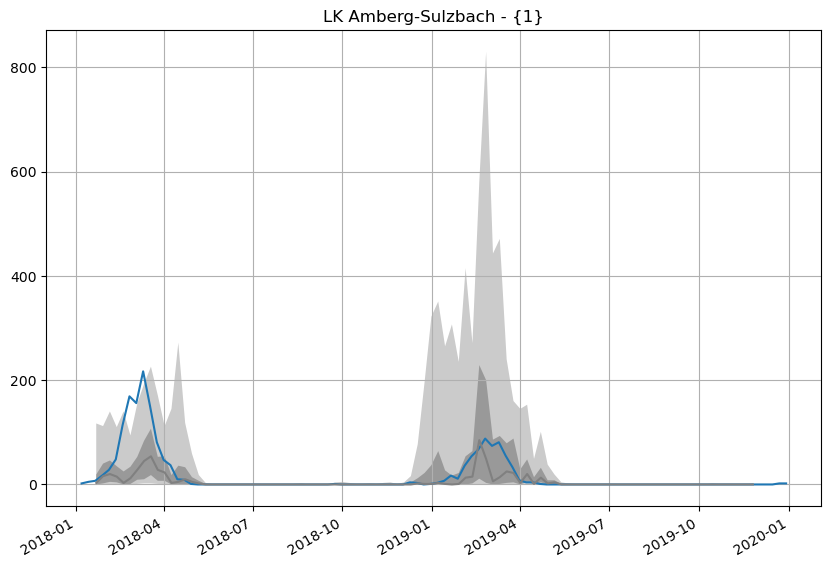

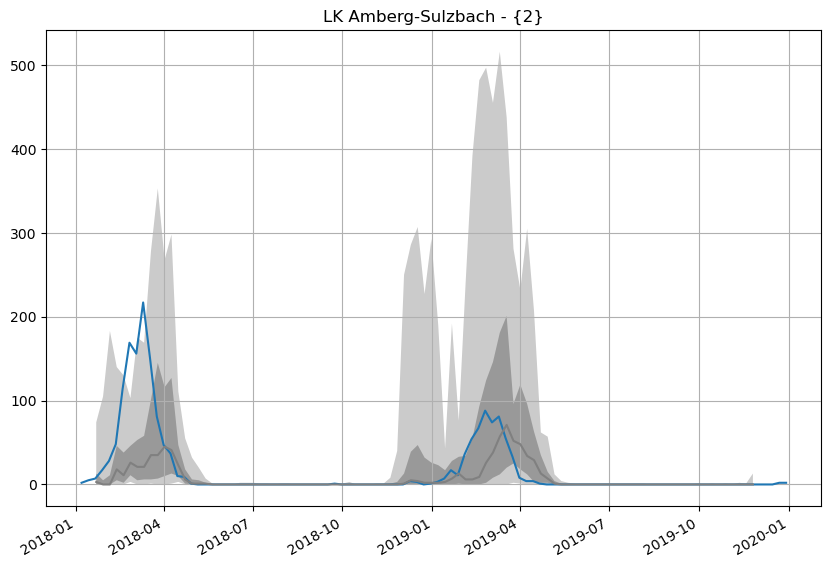

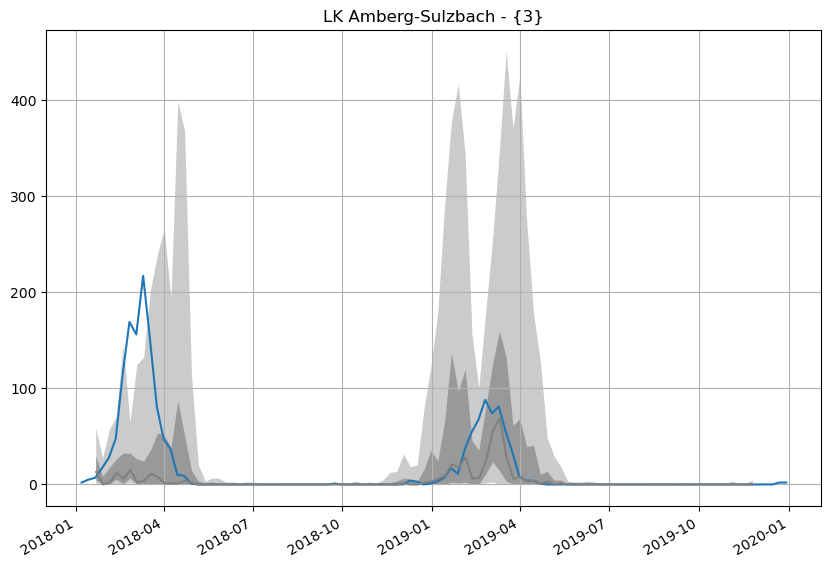

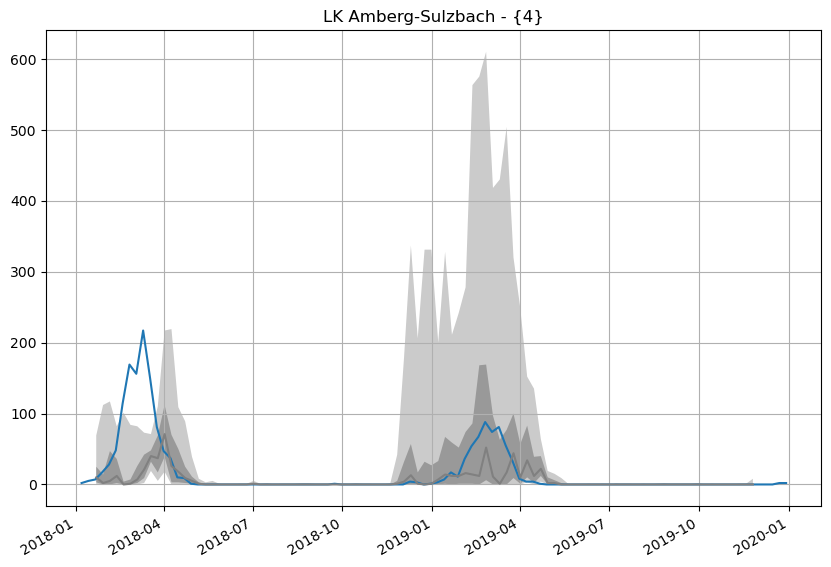

In [4]:
windows_per_location = int(len(test_set) / len(locations))
split_tss = split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[1]
forecast_dict ={1 : split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[0],
                2 : split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)[0],
                3 : split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)[0],
                4 : split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[0]}
for forecast in forecast_dict.values():
    for location in locations[3:4]:
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        d = {key for key in forecast_dict if forecast_dict[key] == forecast}
        plt.title(f'{location} - {d}')
        # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
        plt.plot((corrected_df.loc[(corrected_df['location'] == location) &
                                (corrected_df.index <= config.test_end_time) &
                                (corrected_df.index >= config.train_end_time)].index),
                 corrected_df.loc[(corrected_df['location'] == location) &
                               (corrected_df.index <= config.test_end_time) &
                               (corrected_df.index >= config.train_end_time), 'value'])
        #define the colors to use for each different window
        color = ["g", "purple", "black", "grey","yellow"]*windows_per_location
        forecast_entry = forecast[locations.index(location)]
        prediction_intervals = (50.0, 90.0)
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[int(locations.index(location)) % windows_per_location])
        plt.grid(which="both")
        plt.show()

In [5]:
evaluator = Evaluator(quantiles=config.quantiles)
evaluator_df = pd.DataFrame()
for forecast in forecast_dict.values():
    agg_metrics, item_metrics = evaluator(split_tss, forecast)
    d = {key for key in forecast_dict if forecast_dict[key] == forecast}
    for location in locations[3:4]:
        item_metrics.loc[item_metrics.item_id == f"{location}", "item_id"] = f"{location} {d}"
        evaluator_df = pd.concat([evaluator_df, item_metrics[item_metrics.item_id == f"{location} {d}"]])
    agg_metrics["item_id"] = f"aggregated {d}"
    evaluator_df = pd.concat([evaluator_df, pd.DataFrame(agg_metrics,index=[0])])
print(evaluator_df)

Running evaluation: 411it [00:01, 375.53it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 358.13it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 392.02it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 396.77it/s]


                  item_id         forecast_start          MSE  abs_error  \
8  LK Amberg-Sulzbach {1}  2018-01-22/2018-01-28  1439.396424     1222.0   
0          aggregated {1}                    NaT  1755.203298   399522.0   
8  LK Amberg-Sulzbach {2}  2018-01-22/2018-01-28  1628.972455     1254.0   
0          aggregated {2}                    NaT  1818.908602   406858.0   
8  LK Amberg-Sulzbach {3}  2018-01-22/2018-01-28  1088.484214     1231.0   
0          aggregated {3}                    NaT  1745.099239   432887.0   
8  LK Amberg-Sulzbach {4}  2018-01-22/2018-01-28  1455.517719     1288.0   
0          aggregated {4}                    NaT  2123.867862   442163.0   

   abs_target_sum  abs_target_mean  seasonal_error      MASE      MAPE  \
8          1637.0        16.876289        1.834975  6.865454  1.069404   
0        528476.0        13.288308        1.452949  6.752266  0.851877   
8          1637.0        16.876289        1.834975  7.045236  1.557683   
0        528476.0  

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [6]:
#print(evaluator_df[evaluator_df.index == 0].to_string())
with pd.option_context('display.max_rows', None,'display.max_columns', None,
    'display.precision', 3,):
    print(evaluator_df[evaluator_df.index == 0])

          item_id forecast_start       MSE  abs_error  abs_target_sum  \
0  aggregated {1}            NaT  1514.453   321366.0        528476.0   
0  aggregated {2}            NaT  2032.259   387647.0        528476.0   
0  aggregated {3}            NaT  2251.412   433894.0        528476.0   
0  aggregated {4}            NaT  3593.011   465028.0        528476.0   

   abs_target_mean  seasonal_error   MASE   MAPE  sMAPE     ND     MSIS  \
0           13.288           1.453  5.534  0.774  1.095  0.608   79.139   
0           13.288           1.453  6.654  1.043  1.176  0.734   92.410   
0           13.288           1.453  7.371  1.035  1.289  0.821  100.135   
0           13.288           1.453  7.882  0.991  1.393  0.880  135.154   

   QuantileLoss[0.025]  Coverage[0.025]  QuantileLoss[0.1]  Coverage[0.1]  \
0             26174.15        1.785e-03            99369.2      5.532e-03   
0             26340.45        3.017e-04           102942.0      3.772e-03   
0             26426.70     

### DeepRenewalProcessEstimator -> Acceptable

In [13]:
from gluonts.model.renewal import DeepRenewalProcessEstimator

estimator = DeepRenewalProcessEstimator(
                                       prediction_length=config.prediction_length,
                                       context_length=config.context_length,
                                       num_cells=config.num_cells,
                                       num_layers=config.num_layers,
                                       size_distr_output=config.distr_output,
                                       interval_distr_output=config.distr_output,
                                       trainer=config.trainer
                               )
predictor = estimator.train(train_set)


forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_set, # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_it)
tss = list(ts_it)

100%|██████████| 50/50 [00:01<00:00, 46.19it/s, epoch=4/4, avg_epoch_loss=1.69]


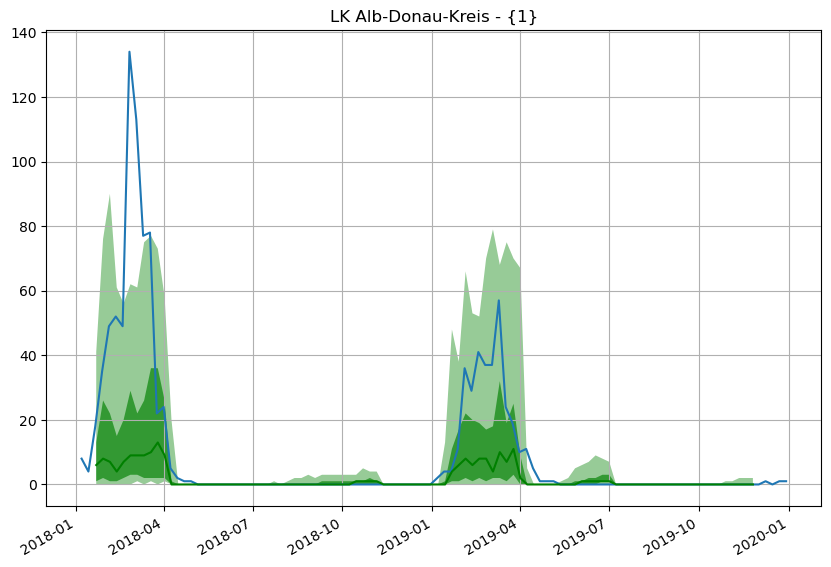

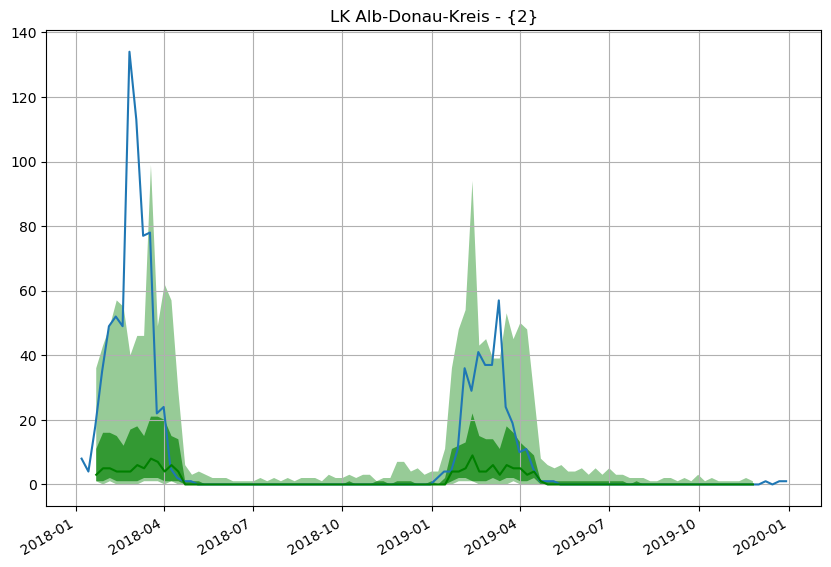

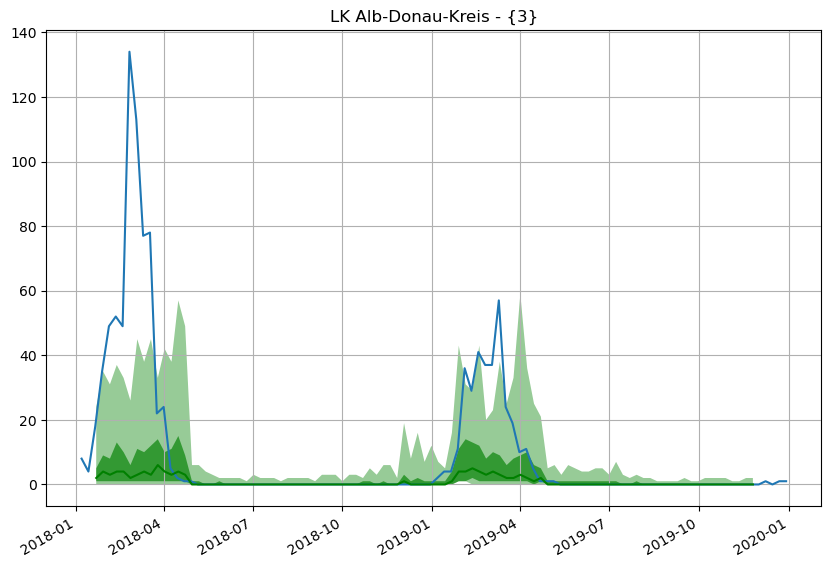

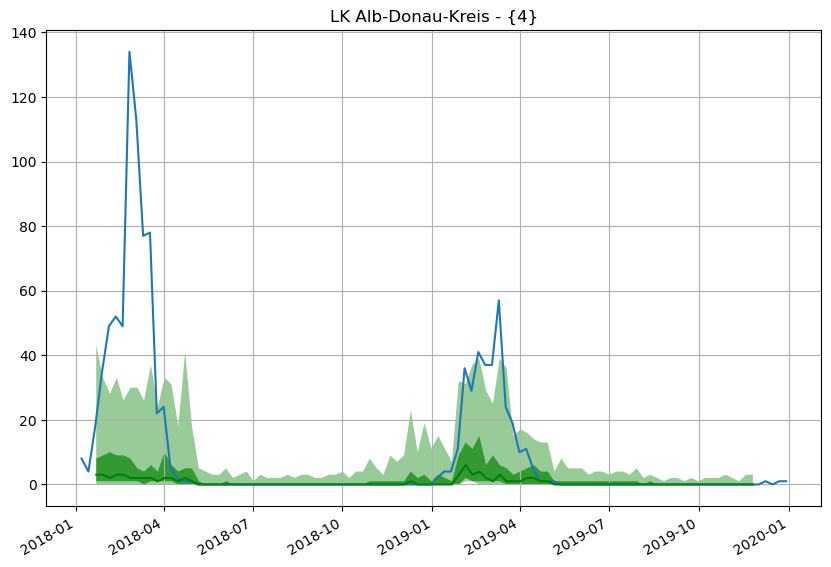

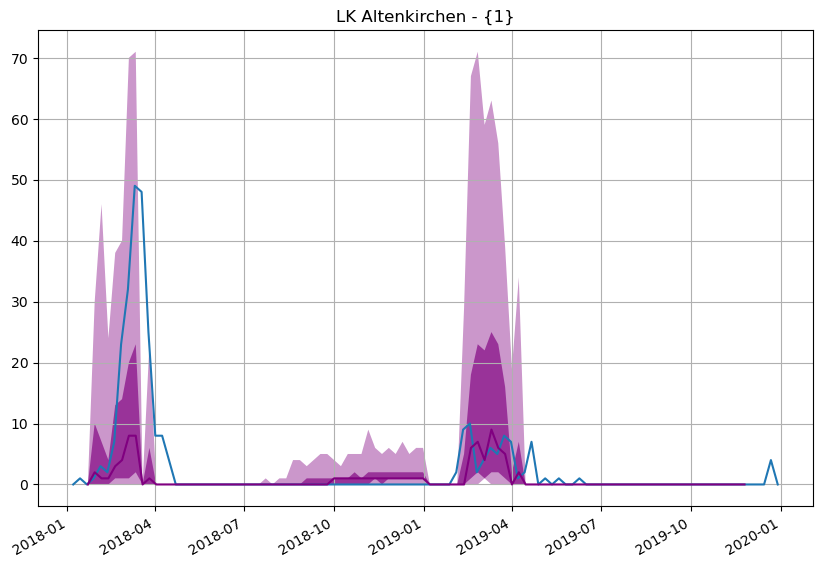

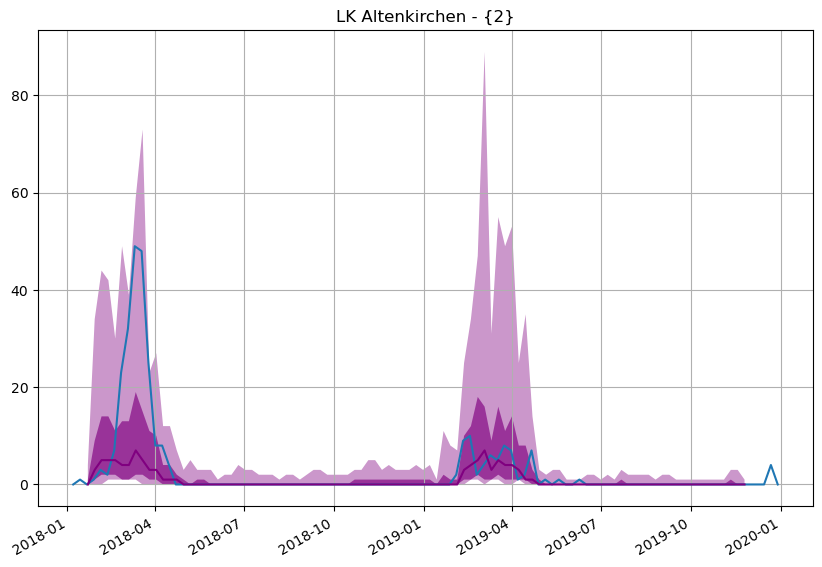

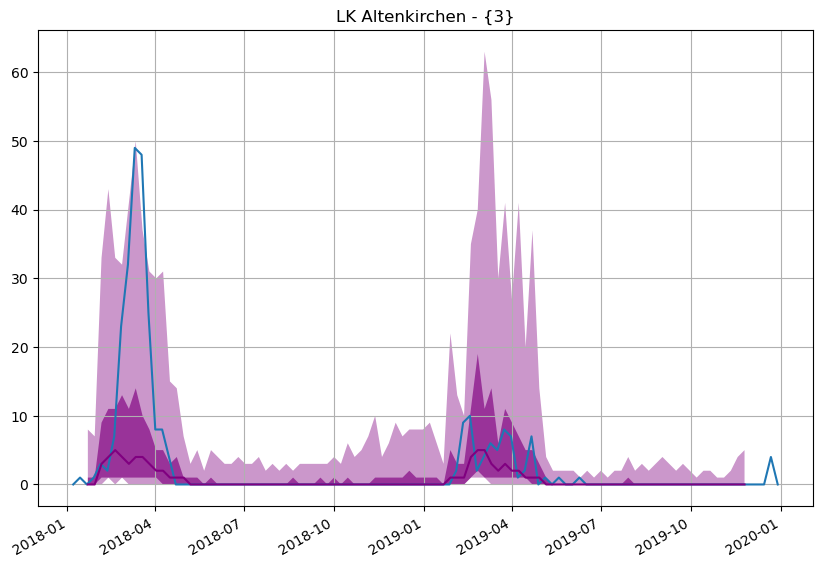

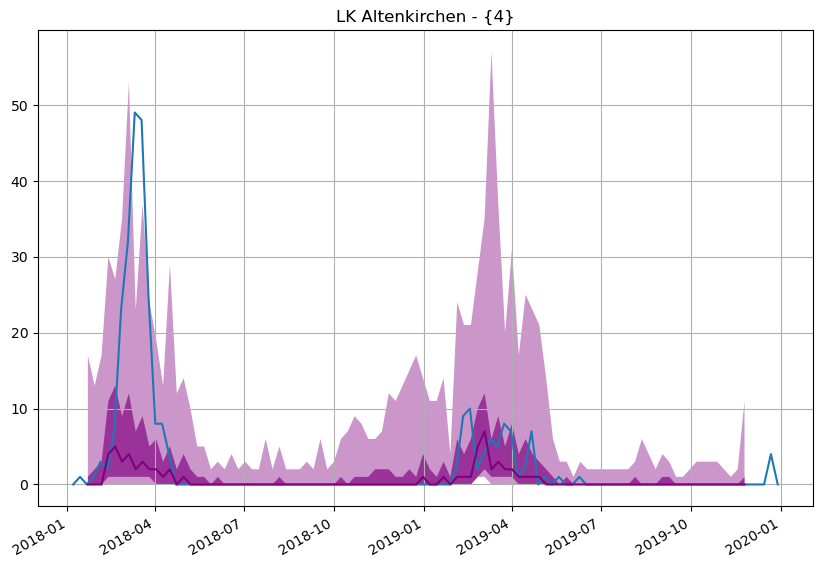

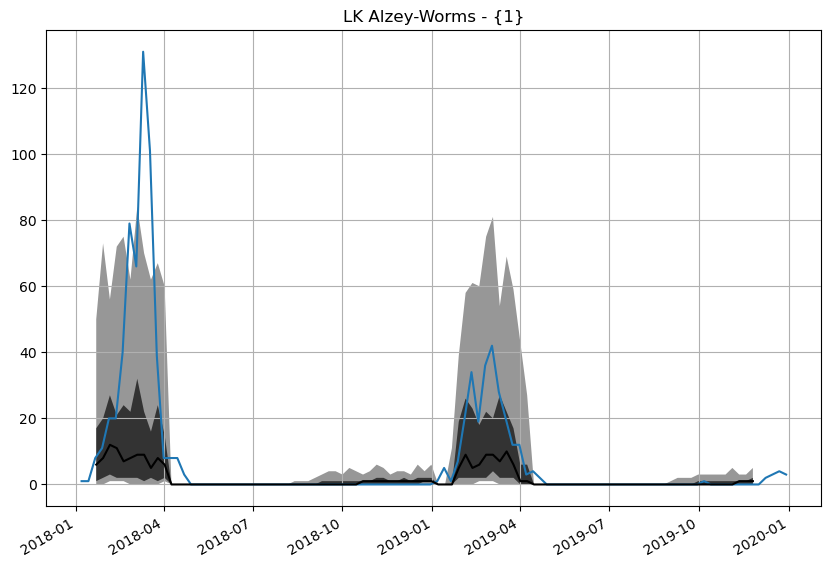

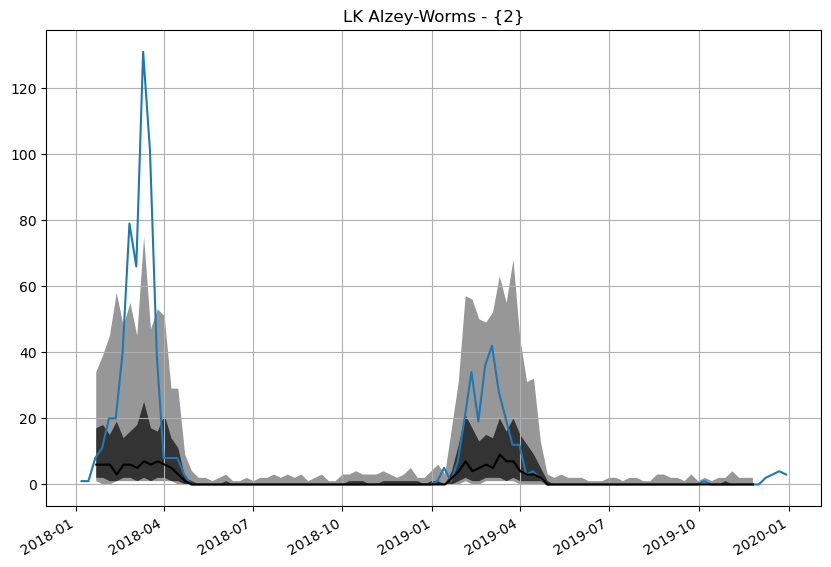

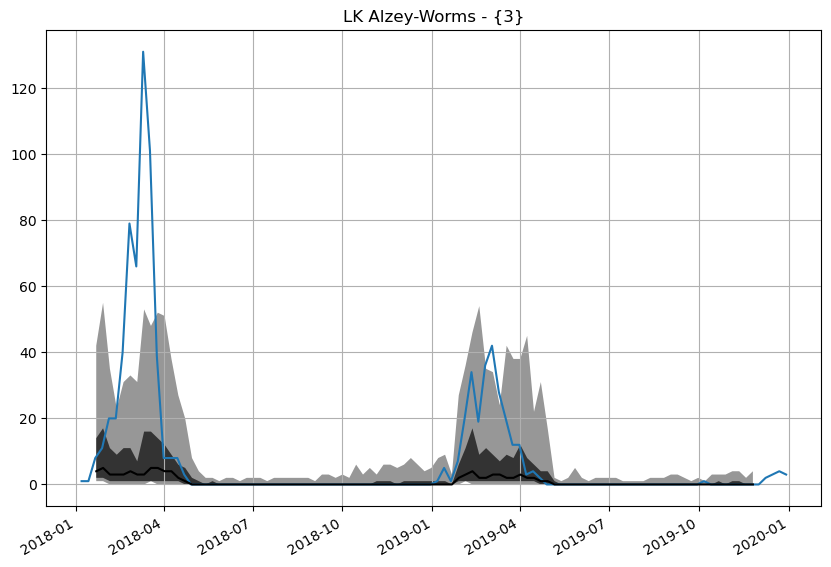

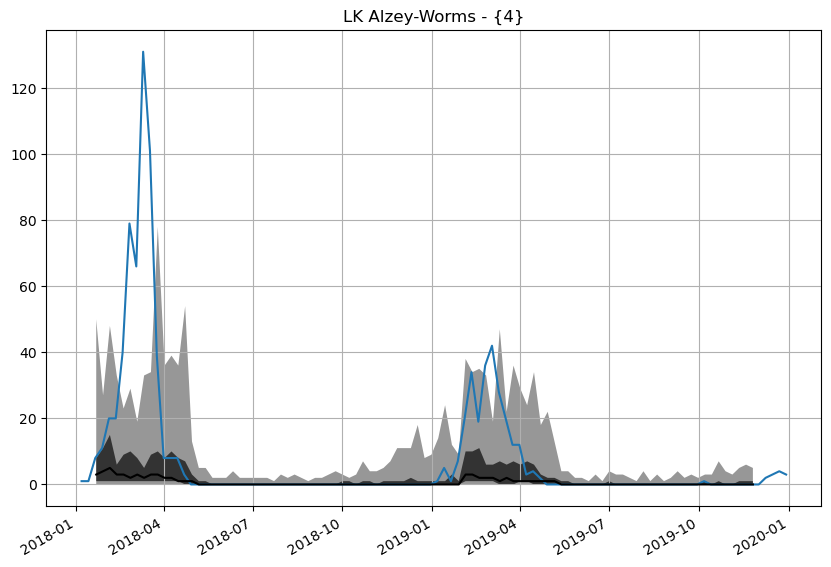

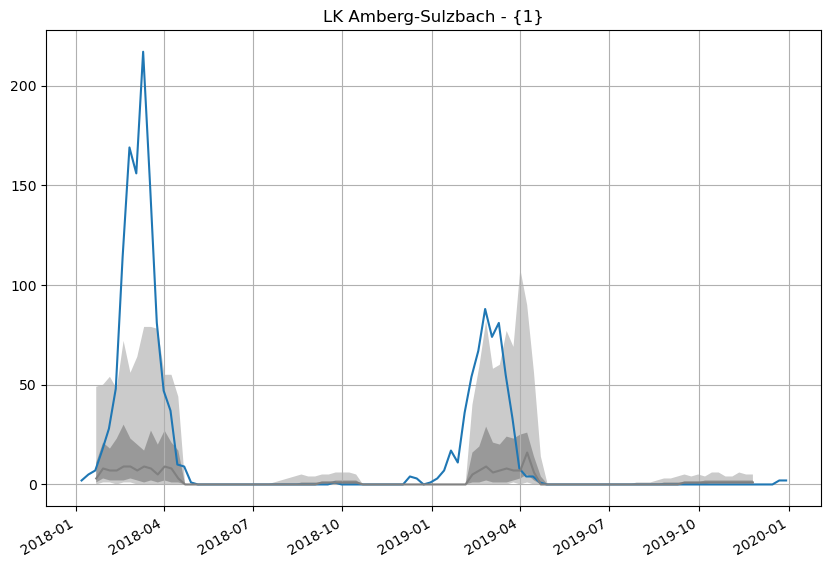

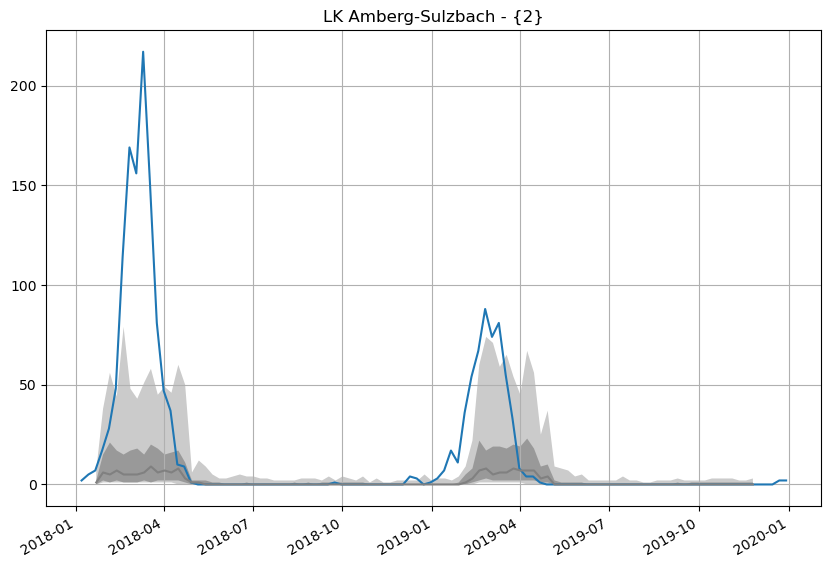

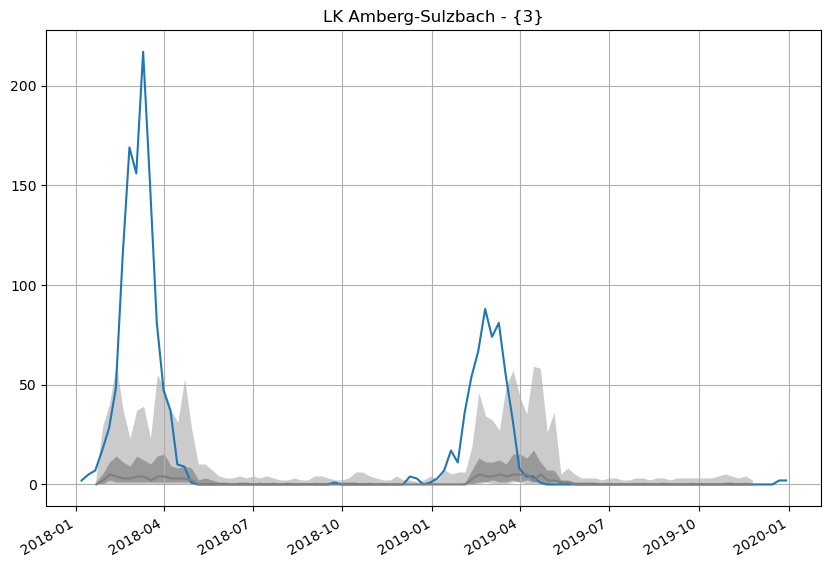

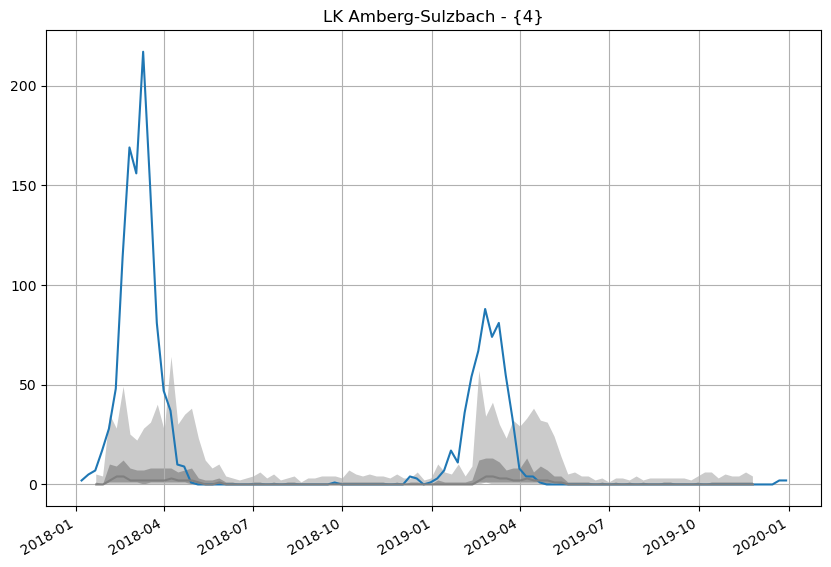

In [14]:
windows_per_location = int(len(test_set) / len(locations))
forecast_dict ={1 : split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[0],
                2 : split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)[0],
                3 : split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)[0],
                4 : split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[0]}
for location in locations[:4]:
    for forecast in forecast_dict.values():
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        d = {key for key in forecast_dict if forecast_dict[key] == forecast}
        plt.title(f'{location} - {d}')
        # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
        plt.plot((corrected_df.loc[(corrected_df['location'] == location) &
                                (corrected_df.index <= config.test_end_time) &
                                (corrected_df.index >= config.train_end_time)].index),
                 corrected_df.loc[(corrected_df['location'] == location) &
                               (corrected_df.index <= config.test_end_time) &
                               (corrected_df.index >= config.train_end_time), 'value'])
        #define the colors to use for each different window
        color = ["g", "purple", "black", "grey","yellow"]*windows_per_location
        forecast_entry = forecast[locations.index(location)]
        prediction_intervals = (50.0, 90.0)
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[int(locations.index(location)) % windows_per_location])
        plt.grid(which="both")
        plt.show()

### WaveNet -> Produces weird forecast (similar to QuantileForecast)

In [26]:
from gluonts.model.wavenet import WaveNetEstimator
estimator = WaveNetEstimator(freq=config.freq,
                          trainer=config.trainer,
                          prediction_length=config.prediction_length,
                          )
predictor = estimator.train(train_set)


forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_set, # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evalucation
)
forecasts = list(forecast_it)
tss = list(ts_it)

100%|██████████| 50/50 [00:02<00:00, 24.33it/s, epoch=4/4, avg_epoch_loss=1.41]


In [28]:
print(forecasts[0])

gluonts.model.forecast.SampleForecast(info=None, item_id="LK Ahrweiler", samples=numpy.array([[0.04704301059246063, 0.04704301059246063, 0.04704301059246063, 0.04704301059246063], [0.04704301059246063, 0.04704301059246063, 0.04704301059246063, 48.125], [0.04704301059246063, 0.04704301059246063, 31.518817901611328, 0.04704301059246063], [0.04704301059246063, 0.04704301059246063, 0.04704301059246063, 0.04704301059246063], [0.04704301059246063, 0.04704301059246063, 0.04704301059246063, 0.04704301059246063], [0.04704301059246063, 0.04704301059246063, 0.04704301059246063, 0.04704301059246063], [0.04704301059246063, 0.04704301059246063, 0.04704301059246063, 0.04704301059246063], [0.04704301059246063, 0.04704301059246063, 0.04704301059246063, 0.04704301059246063], [0.04704301059246063, 0.04704301059246063, 0.04704301059246063, 0.04704301059246063], [0.04704301059246063, 0.04704301059246063, 0.04704301059246063, 0.04704301059246063], [0.04704301059246063, 0.04704301059246063, 0.047043010592460

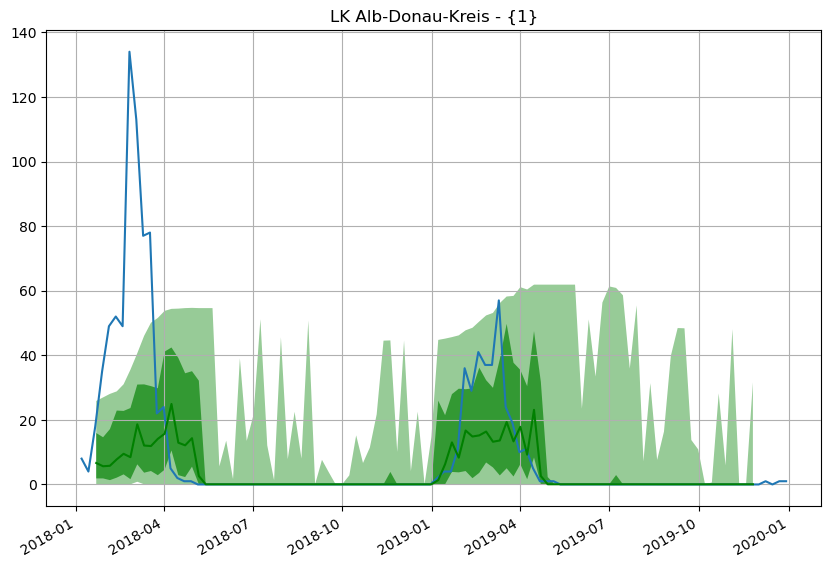

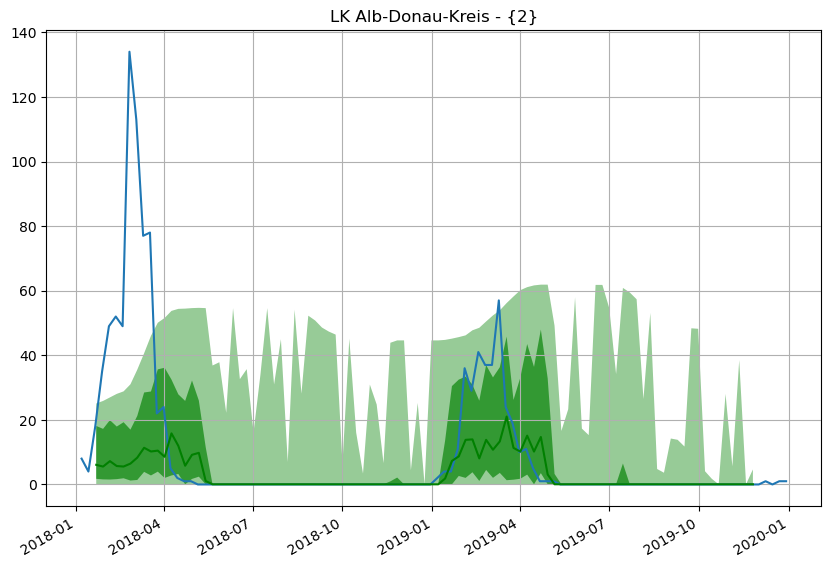

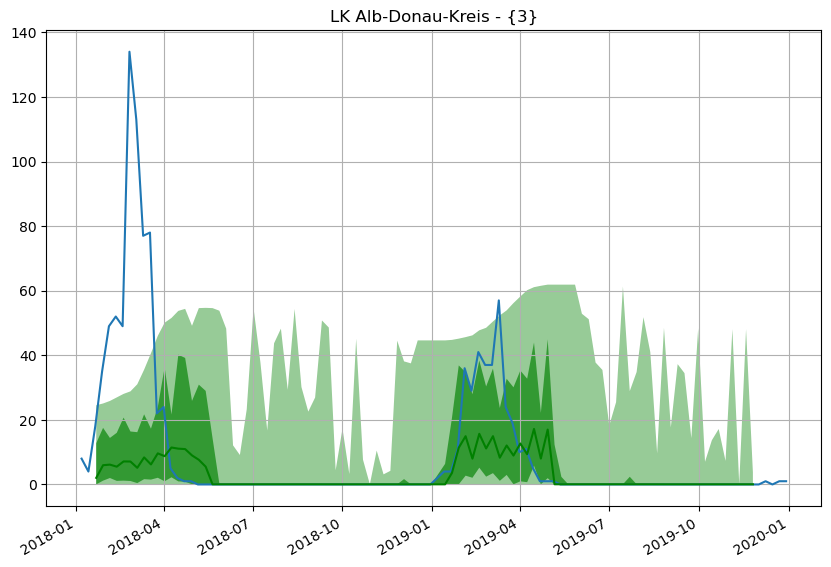

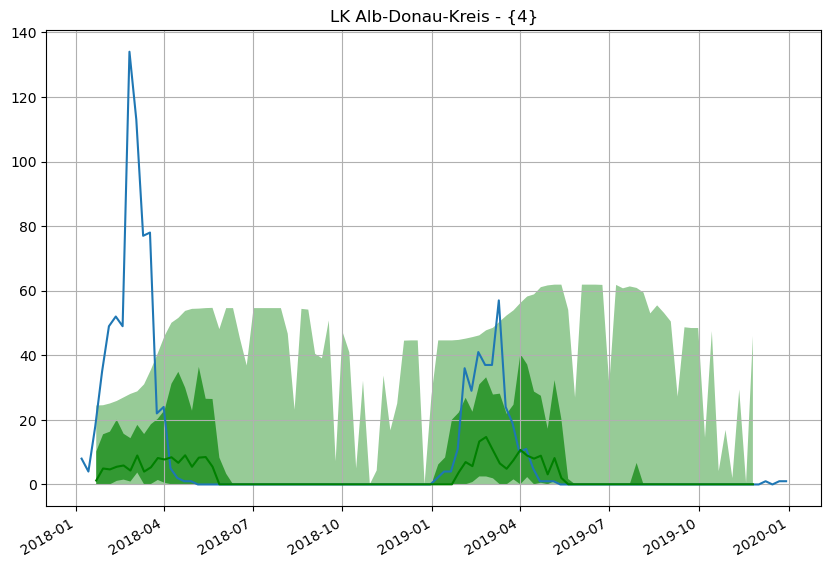

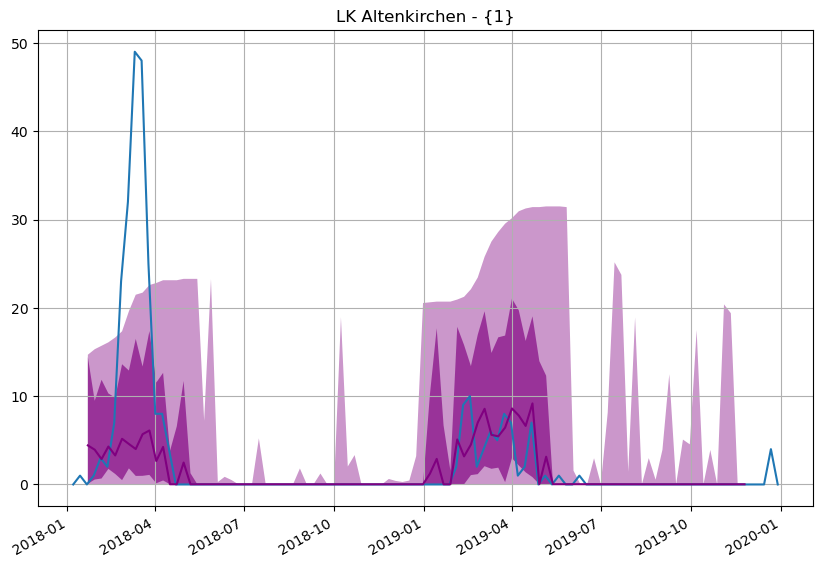

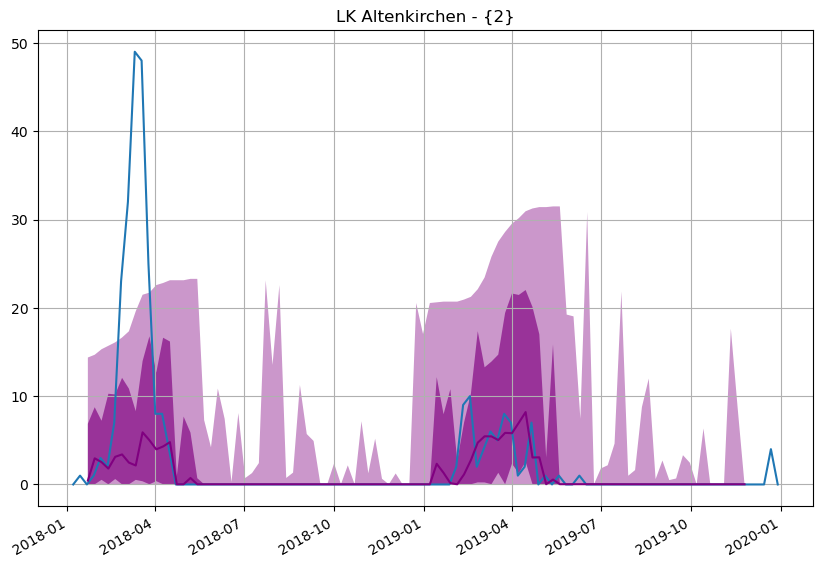

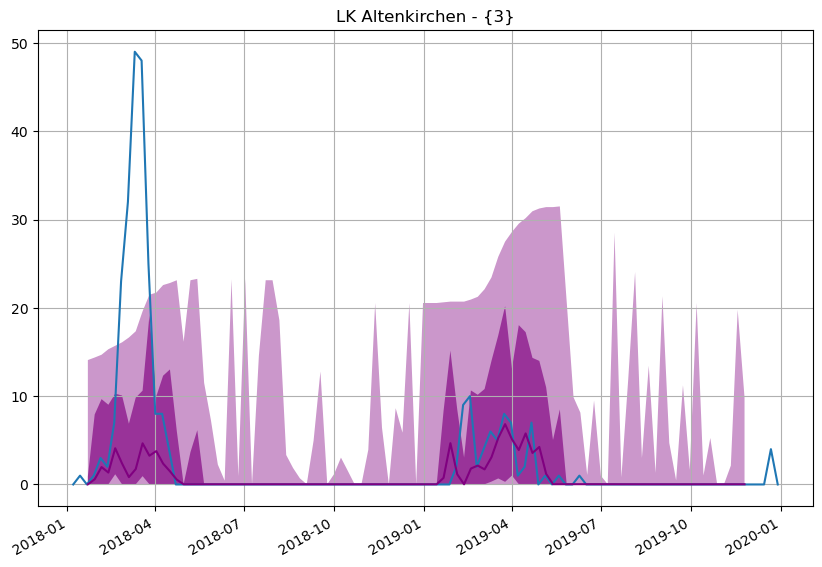

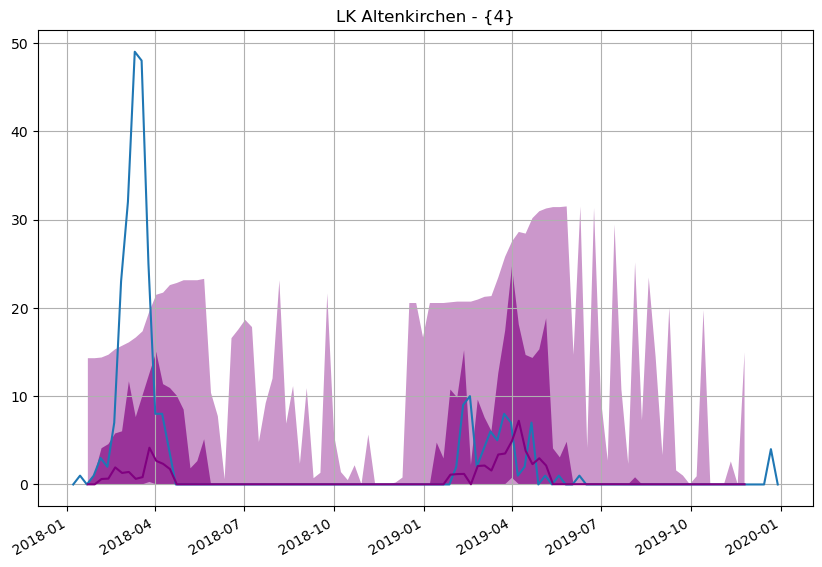

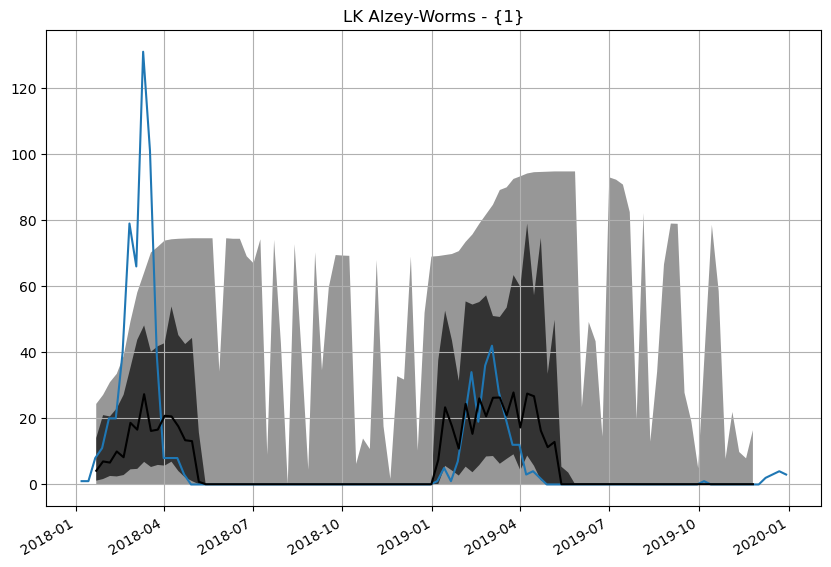

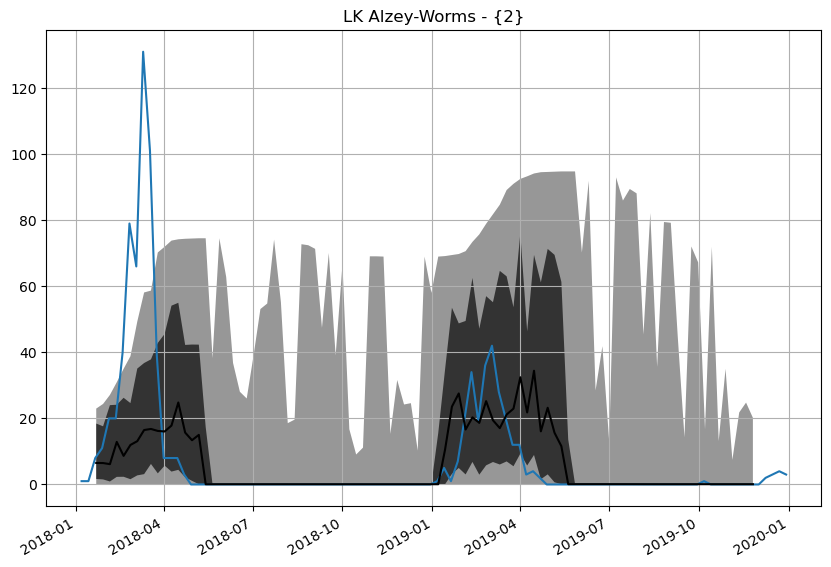

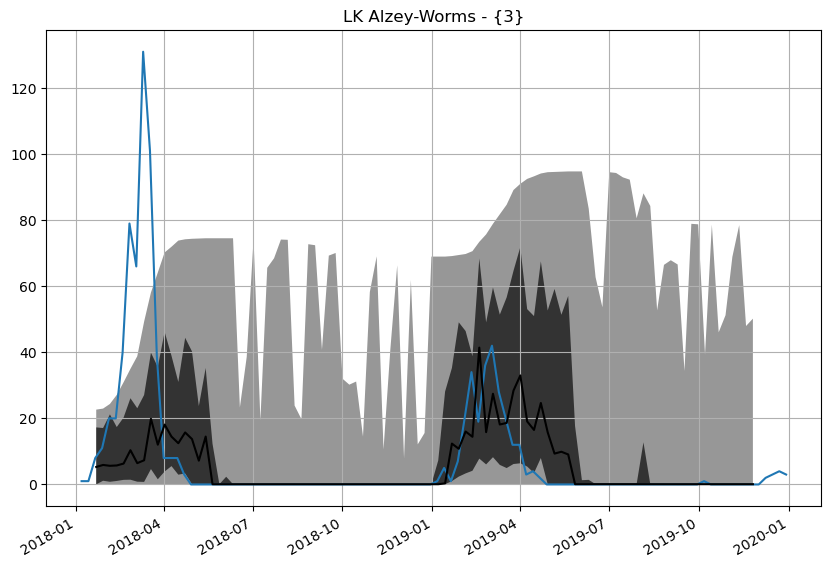

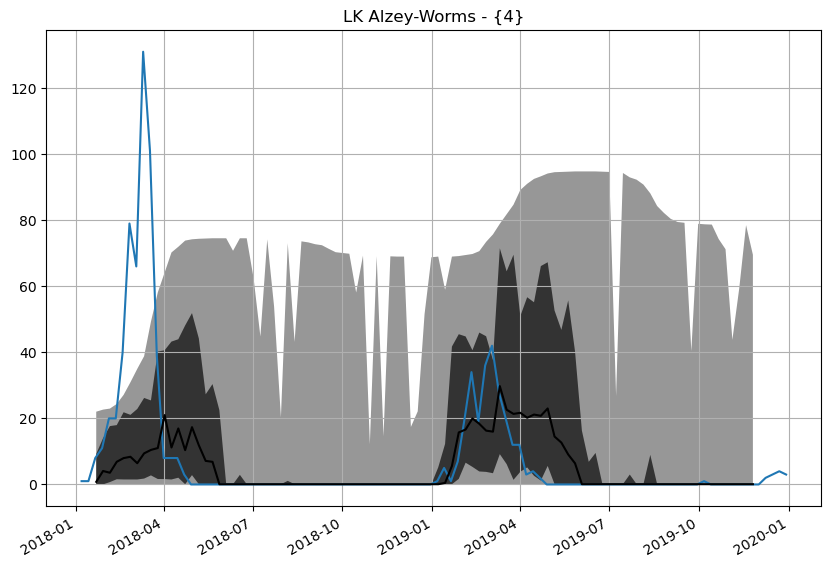

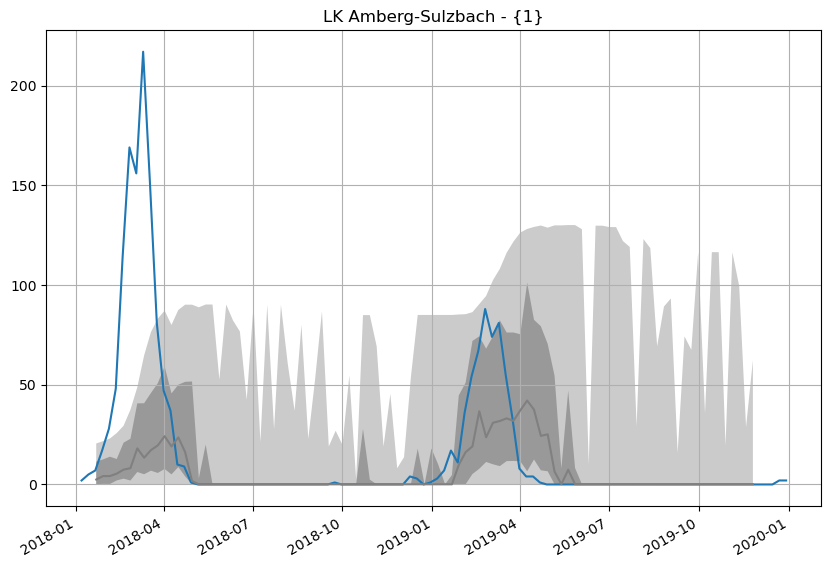

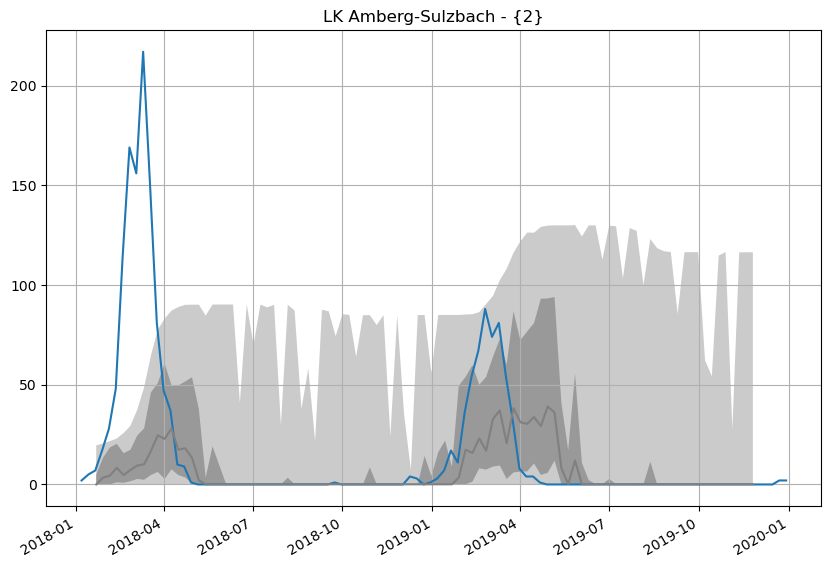

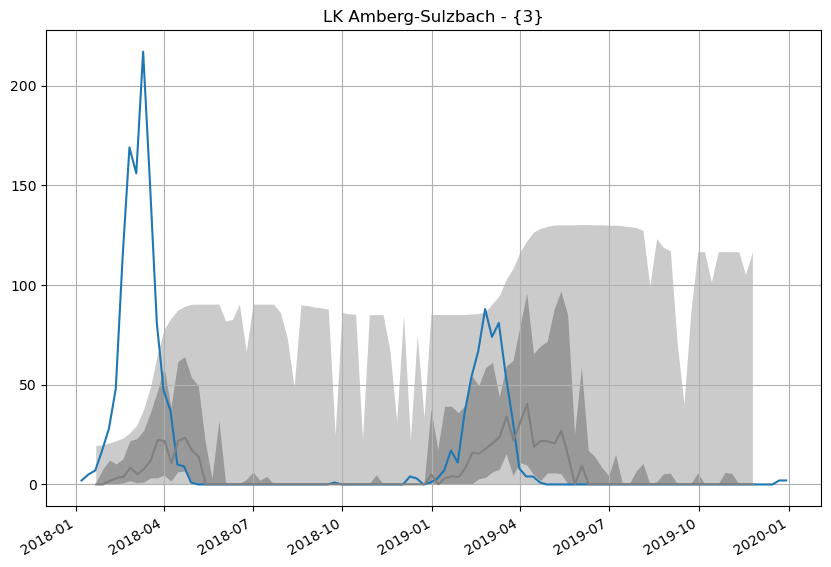

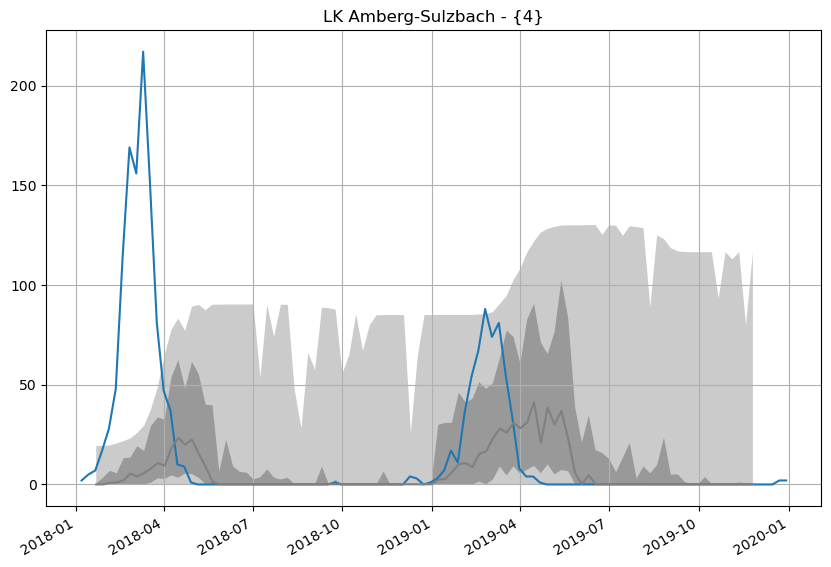

In [19]:
windows_per_location = int(len(test_set) / len(locations))
forecast_dict ={1 : split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[0],
                2 : split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)[0],
                3 : split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)[0],
                4 : split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[0]}
for location in locations[:4]:
    for forecast in forecast_dict.values():
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        d = {key for key in forecast_dict if forecast_dict[key] == forecast}
        plt.title(f'{location} - {d}')
        # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
        plt.plot((corrected_df.loc[(corrected_df['location'] == location) &
                                (corrected_df.index <= config.test_end_time) &
                                (corrected_df.index >= config.train_end_time)].index),
                 corrected_df.loc[(corrected_df['location'] == location) &
                               (corrected_df.index <= config.test_end_time) &
                               (corrected_df.index >= config.train_end_time), 'value'])
        #define the colors to use for each different window
        color = ["g", "purple", "black", "grey","yellow"]*windows_per_location
        forecast_entry = forecast[locations.index(location)]
        prediction_intervals = (50.0, 90.0)
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[int(locations.index(location)) % windows_per_location])
        plt.grid(which="both")
        plt.show()

### MQRNNEstimator -> Produces Quantile Forecast

In [21]:
from gluonts.model.seq2seq import MQRNNEstimator
estimator = MQRNNEstimator(freq=config.freq,
                          trainer=config.trainer,
                          prediction_length=config.prediction_length,
                          context_length=config.context_length
                          )
predictor = estimator.train(train_set)


forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_set, # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evalucation
)
forecasts = list(forecast_it)
tss = list(ts_it)

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/gluonts/model/seq2seq/__init__.py:23: FutureWarning: The module gluonts.model.seq2seq has been moved to gluonts.mx.model.seq2seq. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import MQCNNEstimator, MQRNNEstimator, RNN2QRForecaster, Seq2SeqEstimator'.
  warnings.warn(
100%|██████████| 50/50 [00:01<00:00, 28.38it/s, epoch=4/4, avg_epoch_loss=0.146]


QuantileForecast(array([[-0.21602036,  0.07018495,  0.44865468,  0.69671404],
       [-0.21602036,  0.07018495,  0.44865468,  0.69671404],
       [ 0.15623309,  0.48072845,  0.8544296 ,  0.87654036],
       [ 0.15623309,  0.48072845,  0.8544296 ,  0.87654036],
       [ 0.15623309,  0.48072845,  0.8544296 ,  0.87654036],
       [ 0.15623309,  0.48072845,  0.8544296 ,  0.9734881 ],
       [ 0.22100773,  0.9533925 ,  1.139908  ,  1.7449335 ],
       [ 0.57218736,  1.3334904 ,  1.8937085 ,  2.3739984 ],
       [ 0.57218736,  1.3334904 ,  1.8937085 ,  2.3739984 ],
       [ 1.153383  ,  1.646836  ,  2.2229428 ,  2.7149339 ],
       [ 1.9951824 ,  2.5457904 ,  3.5440106 ,  4.0457954 ]],
      dtype=float32)), start_date=Period('2019-12-02/2019-12-08', 'W-SUN'), forecast_keys=['0.025', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '0.975'], item_id='LK Ahrweiler', info=None)


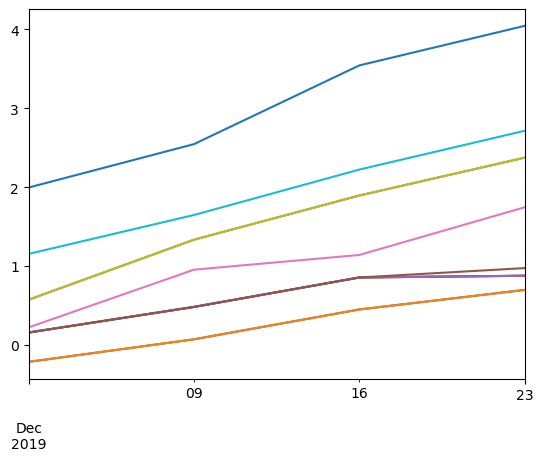

In [24]:
print(forecasts[0])
forecasts[0].plot()

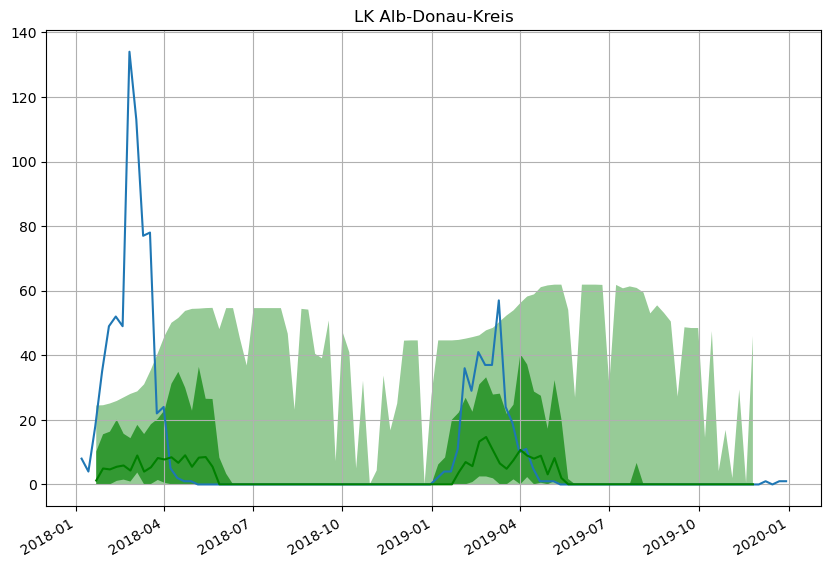

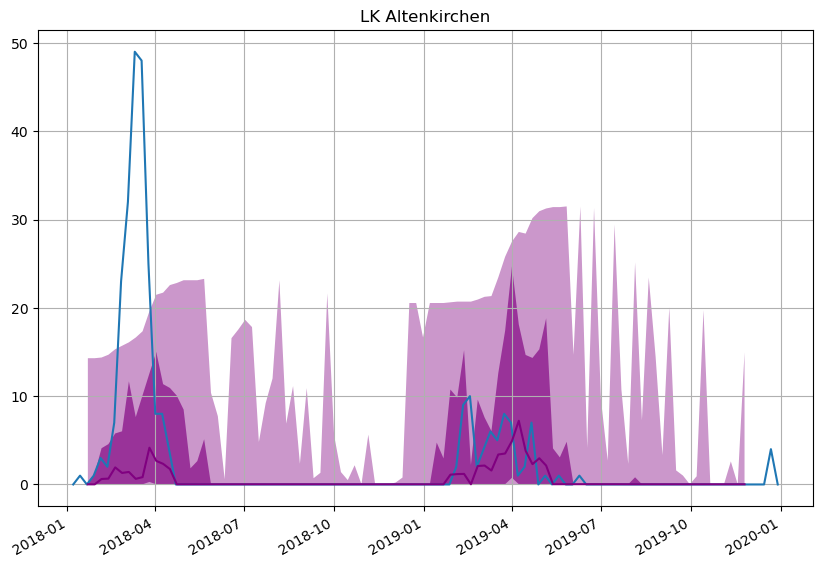

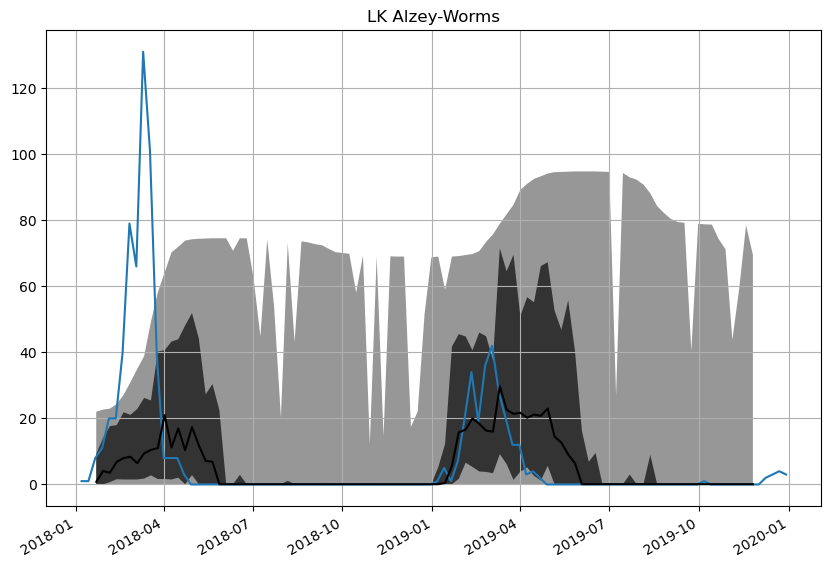

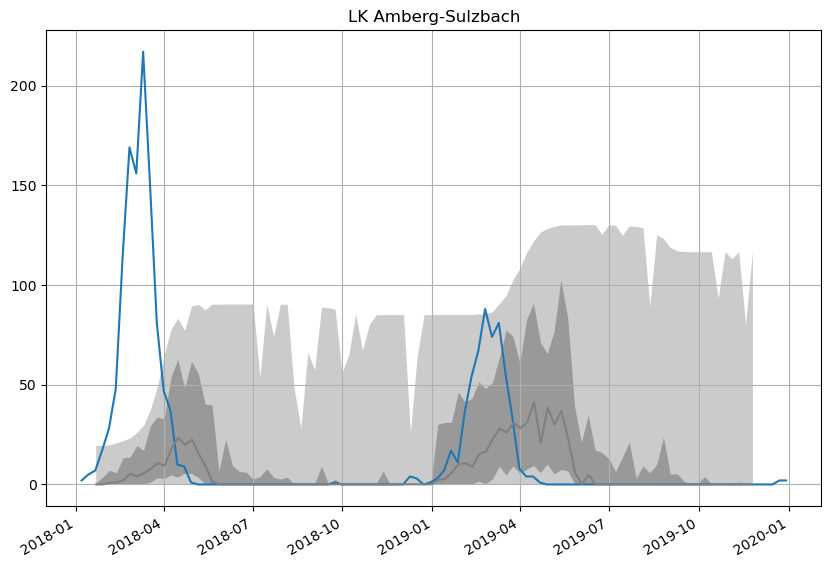

In [25]:
for location in locations[:4]:
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((corrected_df.loc[(corrected_df['location'] == location) &
                            (corrected_df.index <= config.test_end_time) &
                            (corrected_df.index >= config.train_end_time)].index),
             corrected_df.loc[(corrected_df['location'] == location) &
                           (corrected_df.index <= config.test_end_time) &
                           (corrected_df.index >= config.train_end_time), 'value'])
    #define the colors to use for each different window
    color = ["g", "purple", "black", "grey","yellow"]*windows_per_location
    forecast_entry = forecast[locations.index(location)]
    prediction_intervals = (50.0, 90.0)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[int(locations.index(location)) % windows_per_location])
    plt.grid(which="both")
    plt.show()

In [22]:
windows_per_location = int(len(test_set) / len(locations))
forecast_dict ={1 : split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[0],
                2 : split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)[0],
                3 : split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)[0],
                4 : split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[0]}
for location in locations[:4]:
    for forecast in forecast_dict.values():
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        d = {key for key in forecast_dict if forecast_dict[key] == forecast}
        plt.title(f'{location} - {d}')
        # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
        plt.plot((corrected_df.loc[(corrected_df['location'] == location) &
                                (corrected_df.index <= config.test_end_time) &
                                (corrected_df.index >= config.train_end_time)].index),
                 corrected_df.loc[(corrected_df['location'] == location) &
                               (corrected_df.index <= config.test_end_time) &
                               (corrected_df.index >= config.train_end_time), 'value'])
        #define the colors to use for each different window
        color = ["g", "purple", "black", "grey","yellow"]*windows_per_location
        forecast_entry = forecast[locations.index(location)]
        prediction_intervals = (50.0, 90.0)
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[int(locations.index(location)) % windows_per_location])
        plt.grid(which="both")
        plt.show()

AttributeError: 'QuantileForecast' object has no attribute 'samples'

### DeepState -> doesn't work

In [10]:
from gluonts.model.deepstate import DeepStateEstimator

estimator = DeepStateEstimator(freq=config.freq,
                               prediction_length=config.prediction_length,
                               cardinality=[2],
)
predictor = estimator.train(train_set)


forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_set, # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_it)
tss = list(ts_it)

  0%|          | 0/50 [00:00<?, ?it/s]


KeyError: 'feat_static_cat'

### DeepTPP -> doesn't work

In [17]:
from gluonts.mx.model.tpp.deeptpp import DeepTPPEstimator
estimator = DeepTPPEstimator(freq=config.freq,
                          trainer=Trainer(epochs=4, hybridize=False),
                          prediction_interval_length=1,
                          context_interval_length=1,
                          num_marks=3,
                          )
predictor = estimator.train(train_set)


forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_set, # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evalucation
)
forecasts = list(forecast_it)
tss = list(ts_it)

ValidationError: 1 validation error for ContinuousTimeInstanceSplitterModel
freq
  field required (type=value_error.missing)

### NPTS -> doesn't work

In [16]:
from gluonts.model.npts import NPTSPredictor
estimator = NPTSPredictor(freq=config.freq,
                          prediction_length=config.prediction_length,
                          )
predictor = estimator.train(train_set)


forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_set, # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evalucation
)
forecasts = list(forecast_it)
tss = list(ts_it)

AttributeError: 'NPTSPredictor' object has no attribute 'train'

### SeasonalNaive -> doesn't work

In [15]:
from gluonts.model.seasonal_naive import SeasonalNaivePredictor
estimator = SeasonalNaivePredictor(freq=config.freq,
                                   prediction_length=config.prediction_length,
                                   )
predictor = estimator.train(train_set)


forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_set, # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evalucation
)
forecasts = list(forecast_it)
tss = list(ts_it)

AttributeError: 'SeasonalNaivePredictor' object has no attribute 'train'